### dataset link:- https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery

In [1]:
!rm -r /content/sample_data

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip -q install patchify
!pip install segmentation-models-pytorch
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=cab8abeb2ce72de4fb4d30bc89d6f3a7380eada559c7a66ce73c757e34de73b5
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=9f8ba8f0fd57d8f5175d2b998852948371f02fb801d1c31ac7fb60c9a137db61
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

In [23]:
import os
import re
import torch
import cv2
import numpy as np
from pathlib import Path
from patchify import patchify
from PIL import Image
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import torchmetrics

In [4]:
def create_folders():
  FOLDERS = ['train', 'val', 'test']

  for folder in FOLDERS:
    if not os.path.exists(folder):
      folder_imgs = f"{folder}/images"
      folder_msks = f"{folder}/masks"
      os.makedirs(folder_imgs) if not os.path.exists(folder_imgs) else print('folder already exists')
      os.makedirs(folder_msks) if not os.path.exists(folder_msks) else print('folder already exists')

In [5]:
create_folders()

In [6]:
# patches
def create_patches(src, dest_path):
    path_split = os.path.split(src)
    tile_num = re.findall(r'\d+', path_split[0])[0]

    image = Image.open(src)
    image = np.asarray(image)
    if len(image.shape) > 2:  # only if color channel exists as well
        patches = patchify(image, (320, 320, 3), step=300)
        file_name_wo_ext = Path(src).stem
        for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                patch = patches[i, j, 0]
                patch = Image.fromarray(patch)
                num = i * patches.shape[1] + j
                patch.save(f"{dest_path}/{file_name_wo_ext}_tile_{tile_num}_patch_{num}.png")

In [7]:
for path_name, _, file_name in os.walk('/content/drive/MyDrive/colab_notebook/data'):
    for f in file_name:
        print(f)
        if f != 'classes.json':

            path_split = os.path.split(path_name)
            tile_num = re.findall(r'\d+', path_split[0])[0]

            img_type =path_split[1]  # either 'masks' or 'images'

            # leave out tile 2, issues with color dim
            if tile_num == '3':
                target_folder_imgs = 'val'
                target_folder_masks = 'val'
            elif tile_num == '1':
                target_folder_imgs = 'test'
                target_folder_masks = 'test'
            elif tile_num in ['2', '4', '5', '6', '7', '8']:
                target_folder_imgs = 'train'
                target_folder_masks = 'train'

            # copy all images
            src = os.path.join(path_name, f)
            file_name_wo_ext = Path(src).stem
            # check if file exists in images and masks
            img_file = f"{path_split[0]}/images/{file_name_wo_ext}.jpg"
            mask_file = f"{path_split[0]}/masks/{file_name_wo_ext}.png"
            if os.path.exists(img_file) and os.path.exists(mask_file):
                if img_type == 'images':
                    dest = os.path.join(target_folder_imgs, img_type)
                    create_patches(src=src, dest_path=dest)

                # copy all masks
                if img_type == 'masks':
                    dest = os.path.join(target_folder_masks, img_type)
                    create_patches(src=src, dest_path=dest)

classes.json
image_part_005.png
image_part_006.png
image_part_003.png
image_part_004.png
image_part_007.png
image_part_002.png
image_part_009.png
image_part_001.png
image_part_008.png
image_part_002.jpg
image_part_003.jpg
image_part_006.jpg
image_part_009.jpg
image_part_007.jpg
image_part_004.jpg
image_part_001.jpg
image_part_005.jpg
image_part_008.jpg
image_part_005.png
image_part_002.png
image_part_008.png
image_part_003.png
image_part_009.png
image_part_006.png
image_part_007.png
image_part_004.png
image_part_001.png
image_part_007.jpg
image_part_009.jpg
image_part_004.jpg
image_part_005.jpg
image_part_001.jpg
image_part_008.jpg
image_part_006.jpg
image_part_002.jpg
image_part_003.jpg
image_part_001.jpg
image_part_009.jpg
image_part_002.jpg
image_part_008.jpg
image_part_003.jpg
image_part_004.jpg
image_part_006.jpg
image_part_007.jpg
image_part_005.jpg
image_part_005.png
image_part_007.png
image_part_006.png
image_part_001.png
image_part_002.png
image_part_004.png
image_part_003.png

---------------------------------------------------------------------------

In [8]:
class SegmentationDataset(Dataset):
    """Create Semantic Segmentation Dataset. Read images, apply augmentations, and process transformations

    Args:
        Dataset (image): Aerial Drone Images
    """
    # CLASSES = {'building': 44, 'land': 91, 'road':172, 'vegetation':212, 'water':171, 'unlabeled':155}
    # CLASSES_KEYS = list(CLASSES.keys())

    def __init__(self, path_name) -> None:
        super().__init__()
        self.image_names = os.listdir(f"{path_name}/images")
        self.image_paths = [f"{path_name}/images/{i}" for i in self.image_names]
        self.masks_names = os.listdir(f"{path_name}/masks")
        self.masks_paths = [f"{path_name}/masks/{i}" for i in self.masks_names]

        # filter all images that do not exist in both folders
        self.img_stem = [Path(i).stem for i in self.image_paths]
        self.msk_stem = [Path(i).stem for i in self.masks_paths]
        self.img_msk_stem = set(self.img_stem) & set(self.msk_stem)
        self.image_paths = [i for i in self.image_paths if (Path(i).stem in self.img_msk_stem)]


    def convert_mask(self, mask):
        mask[mask == 155] = 0  # unlabeled
        mask[mask == 44] = 1  # building
        mask[mask == 91] = 2  # land
        mask[mask == 171] = 3  # water
        mask[mask == 172] = 4  # road
        mask[mask == 212] = 5  # vegetation
        return mask

    def __len__(self):
        return len(self.img_msk_stem)

    def __getitem__(self, index):
        image = cv2.imread(self.image_paths[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.transpose((2, 0, 1))  #structure: BS, C, H, W
        mask =  cv2.imread(self.masks_paths[index], 0)
        mask = self.convert_mask(mask)
        return image, mask

In [9]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
# Hyperparameters
EPOCHS = 75
BS = 2

In [11]:
train_ds = SegmentationDataset(path_name='train')
train_dataloader = DataLoader(train_ds, batch_size=BS, shuffle=True)
val_ds = SegmentationDataset(path_name='val')
val_dataloader = DataLoader(val_ds, batch_size=BS, shuffle=True)

In [12]:
model = smp.FPN(
    encoder_name='resnext50_32x4d',
    encoder_weights='imagenet',
    classes=6,
    activation='sigmoid',
)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 112MB/s]


In [13]:
model.to(DEVICE)

FPN(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [14]:
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

In [15]:
# criterion = nn.CrossEntropyLoss()
criterion = smp.losses.DiceLoss(mode='multiclass')

In [16]:
train_losses, val_losses = [], []

In [17]:
for e in range(EPOCHS):
    model.train()
    running_train_loss, running_val_loss = 0, 0
    for i, data in enumerate(train_dataloader):
        #training phase
        image_i, mask_i = data
        image = image_i.to(DEVICE)
        mask = mask_i.to(DEVICE)

        # reset gradients
        optimizer.zero_grad()
        #forward
        output = model(image.float())

        # calc losses
        train_loss = criterion(output.float(), mask.long())

        # back propagation
        train_loss.backward()
        optimizer.step() #update weight

        running_train_loss += train_loss.item()
    train_losses.append(running_train_loss)

    # validation
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_dataloader):
            image_i, mask_i = data
            image = image_i.to(DEVICE)
            mask = mask_i.to(DEVICE)
            #forward
            output = model(image.float())
            # calc losses
            val_loss = criterion(output.float(), mask.long())
            running_val_loss += val_loss.item()
    val_losses.append(running_val_loss)


    print(f"Epoch: {e}: Train Loss: {np.median(running_train_loss)}, Val Loss: {np.median(running_val_loss)}")

Epoch: 0: Train Loss: 191.79850541055202, Val Loss: 13.654845416545868
Epoch: 1: Train Loss: 188.42129614204168, Val Loss: 13.502369999885559
Epoch: 2: Train Loss: 182.86903309077024, Val Loss: 13.28552559018135
Epoch: 3: Train Loss: 182.45820820331573, Val Loss: 13.849875926971436
Epoch: 4: Train Loss: 182.83268916606903, Val Loss: 12.965107187628746
Epoch: 5: Train Loss: 180.62890928983688, Val Loss: 13.575059175491333
Epoch: 6: Train Loss: 181.09280912578106, Val Loss: 13.547450184822083
Epoch: 7: Train Loss: 180.29330424964428, Val Loss: 12.858232781291008
Epoch: 8: Train Loss: 180.39349761605263, Val Loss: 12.321610637009144
Epoch: 9: Train Loss: 180.35304379463196, Val Loss: 13.451079785823822
Epoch: 10: Train Loss: 178.6503857076168, Val Loss: 13.395092010498047
Epoch: 11: Train Loss: 179.30642879754305, Val Loss: 13.068378299474716
Epoch: 12: Train Loss: 178.3020458072424, Val Loss: 13.414007723331451
Epoch: 13: Train Loss: 179.3855552226305, Val Loss: 13.411106437444687
Epoch:

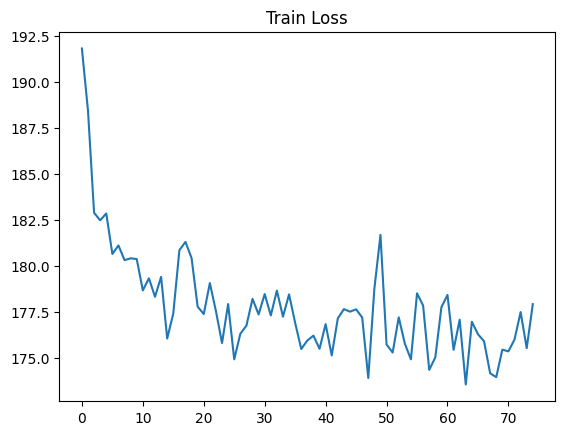

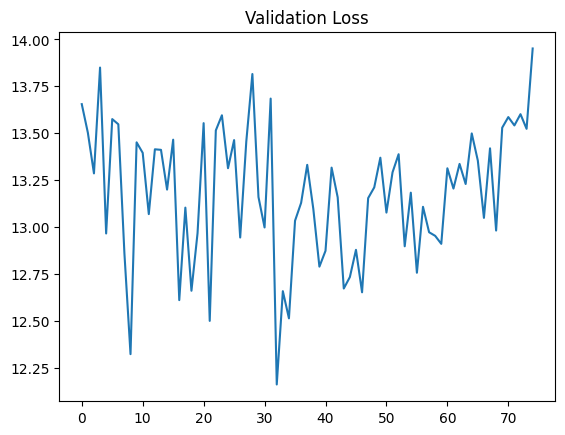

In [18]:
#%% TRAIN LOSS
sns.lineplot(x = range(len(train_losses)), y= train_losses).set(title='Train Loss')
plt.show()
sns.lineplot(x = range(len(train_losses)), y= val_losses).set(title='Validation Loss')
plt.show()

In [21]:
torch.save(model.state_dict(), f'FPN_epochs_{EPOCHS}_crossentropy_state_dict.pth')

### Inference

In [24]:
test_ds = SegmentationDataset(path_name='test')
test_dataloader = DataLoader(test_ds, batch_size=1, shuffle=True)

In [ ]:
model = smp.FPN(
    encoder_name='resnext50_32x4d',
    encoder_weights='imagenet',
    classes=6,
    activation='sigmoid',
)
model.to(DEVICE)

In [27]:
# load weights
model.load_state_dict(torch.load('/content/FPN_epochs_75_crossentropy_state_dict.pth'))

<All keys matched successfully>

In [28]:
# Model Evaluation
pixel_accuracies = []
intersection_over_unions = []
metric_iou = torchmetrics.JaccardIndex(num_classes=6, task='multiclass').to(DEVICE)

In [29]:
with torch.no_grad():
    for data in test_dataloader:
        inputs, outputs = data
        true = outputs.to(torch.float32)
        pred = model(inputs.to(DEVICE).float())
        _, predicted = torch.max(pred, 1)
        true = true.to(DEVICE)
        correct_pixels = (true == predicted).sum().item()
        total_pixels = true.size(1) * true.size(2)
        pixel_accuracies.append(correct_pixels / total_pixels)
        iou = metric_iou(predicted.float(), true).item()
        intersection_over_unions.append(iou)

In [30]:
# Median Accuracy
print(f"Median Pixel Accuracy: {np.median(pixel_accuracies) * 100 }")
print(f"Median IoU: {np.median(intersection_over_unions) * 100 }")

Median Pixel Accuracy: 86.73828125
Median IoU: 32.68789499998093


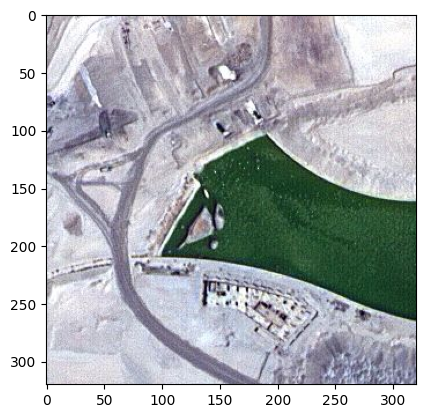

In [32]:
# Pick a test image and show it
image_test, mask = next(iter(test_dataloader))
plt.imshow(np.transpose(image_test[0, :, :, :].cpu().numpy(), (1, 2, 0)));

In [34]:
with torch.no_grad():
    image_test = image_test.float().to(DEVICE)
    output = model(image_test)

output_cpu = output.cpu().squeeze().numpy()
output_cpu = output_cpu.transpose((1, 2, 0))
output_cpu = output_cpu.argmax(axis=2)
output_cpu.shape

(320, 320)

In [35]:
required_range = list(range(6))
output_cpu[0, 0] = 0
output_cpu[0, 1] = 1
output_cpu[0, 2] = 2
output_cpu[0, 3] = 3
output_cpu[0, 4] = 4
output_cpu[0, 5] = 5

mask[0, 0, 0] = 0
mask[0, 0, 1] = 1
mask[0, 0, 2] = 2
mask[0, 0, 3] = 3
mask[0, 0, 4] = 4
mask[0, 0, 5] = 5

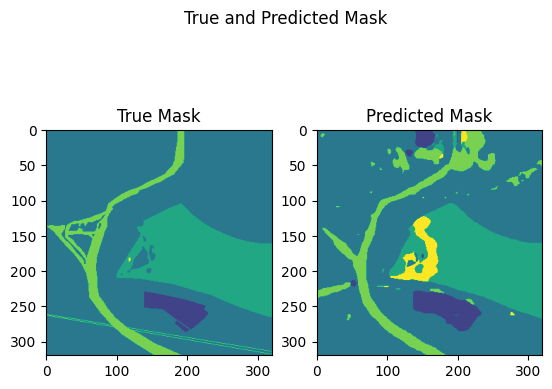

In [36]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.suptitle('True and Predicted Mask')
axs[0].imshow(mask[0, :, :])
axs[1].imshow(output_cpu)
axs[0].set_title("True Mask")
axs[1].set_title("Predicted Mask")
plt.show()